In [ ]:
# INSTALACION DEL REPOSITORIO QUE CONTIENE EL DATASET "Adult Income Classification"
!pip install ucimlrepo

In [ ]:
# ============================================================================
# CONFIGURACIÓN INICIAL Y SEMILLA DE REPRODUCIBILIDAD
# ============================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (classification_report, confusion_matrix,
                            accuracy_score, precision_score, recall_score,
                            f1_score, roc_auc_score, roc_curve, auc)
import warnings
warnings.filterwarnings('ignore')

# Semilla de reproducibilidad
SEED = 42
np.random.seed(SEED)

print("="*80)
print("PRÁCTICA 4: MLP COMO PREDICTOR BINARIO")
print("Dataset: Adult Income Classification")
print("="*80)

PRÁCTICA 4: MLP COMO PREDICTOR BINARIO
Dataset: Adult Income Classification


In [ ]:
# ============================================================================
# CARGA Y EXPLORACIÓN INICIAL DE DATOS
# ============================================================================

from ucimlrepo import fetch_ucirepo

# Fetch dataset
adult = fetch_ucirepo(id=2)
X = adult.data.features
y = adult.data.targets

print("\n[1] INFORMACIÓN DEL DATASET")
print("-" * 80)
print(f"Dimensiones de X: {X.shape}")
print(f"Dimensiones de y: {y.shape}")
print(f"\nPrimeras filas de X:\n{X.head()}")
print(f"\nDistribución de la variable objetivo:\n{y.value_counts()}")
print(f"\nInformación de tipos de datos:\n{X.info()}")

# Convert target to binary: <=50K and <=50K. -> 0, >50K and >50K. -> 1
y_binary = y.copy()
y_binary['income'] = y_binary['income'].replace({'<=50K.': '<=50K', '>50K.': '>50K'})

print(f"\nDistribución de la variable objetivo (binaria):\n{y_binary.value_counts()}")

# Update the target variable to the binary version
y = y_binary


[1] INFORMACIÓN DEL DATASET
--------------------------------------------------------------------------------
Dimensiones de X: (48842, 14)
Dimensiones de y: (48842, 1)

Primeras filas de X:
   age         workclass  fnlwgt  education  education-num  \
0   39         State-gov   77516  Bachelors             13   
1   50  Self-emp-not-inc   83311  Bachelors             13   
2   38           Private  215646    HS-grad              9   
3   53           Private  234721       11th              7   
4   28           Private  338409  Bachelors             13   

       marital-status         occupation   relationship   race     sex  \
0       Never-married       Adm-clerical  Not-in-family  White    Male   
1  Married-civ-spouse    Exec-managerial        Husband  White    Male   
2            Divorced  Handlers-cleaners  Not-in-family  White    Male   
3  Married-civ-spouse  Handlers-cleaners        Husband  Black    Male   
4  Married-civ-spouse     Prof-specialty           Wife  Black  Fe

In [ ]:
# ============================================================================
# ANÁLISIS EXPLORATORIO Y LIMPIEZA DE DATOS
# ============================================================================

print("\n[2] ANÁLISIS EXPLORATORIO Y LIMPIEZA")
print("-" * 80)

# Identificar valores faltantes
missing_values = X.isnull().sum()
print(f"Valores faltantes por columna:\n{missing_values[missing_values > 0]}")

# Eliminar filas con valores faltantes
X_clean = X.dropna()
y_clean = y.loc[X_clean.index]

print(f"\nDimensiones después de limpieza: {X_clean.shape}")

# Estadísticas descriptivas
print(f"\nEstadísticas de variables numéricas:\n{X_clean.describe()}")


[2] ANÁLISIS EXPLORATORIO Y LIMPIEZA
--------------------------------------------------------------------------------
Valores faltantes por columna:
workclass         963
occupation        966
native-country    274
dtype: int64

Dimensiones después de limpieza: (47621, 14)

Estadísticas de variables numéricas:
                age        fnlwgt  education-num  capital-gain  capital-loss  \
count  47621.000000  4.762100e+04   47621.000000  47621.000000  47621.000000   
mean      38.640684  1.897271e+05      10.090821   1091.137649     87.853489   
std       13.558961  1.055695e+05       2.568320   7487.228336    404.010612   
min       17.000000  1.228500e+04       1.000000      0.000000      0.000000   
25%       28.000000  1.175840e+05       9.000000      0.000000      0.000000   
50%       37.000000  1.782820e+05      10.000000      0.000000      0.000000   
75%       48.000000  2.377200e+05      12.000000      0.000000      0.000000   
max       90.000000  1.490400e+06      16.00000

In [ ]:
# ============================================================================
# INGENIERÍA DE CARACTERÍSTICAS Y SELECCIÓN
# ============================================================================

print("\n[3] INGENIERÍA Y SELECCIÓN DE CARACTERÍSTICAS")
print("-" * 80)

# CRITICAL: Limpiar la variable objetivo para clasificación binaria
# El dataset tiene inconsistencias con puntos finales: '<=50K' y '<=50K.', '>50K' y '>50K.'
print("Limpiando variable objetivo...")
y_clean_copy = y_clean.copy()
y_clean_copy = y_clean_copy.iloc[:, 0].astype(str).str.strip().str.rstrip('.')

print(f"Clases originales únicas: {y_clean.iloc[:, 0].unique()}")
print(f"Clases después de limpieza: {y_clean_copy.unique()}")

# Verificar que solo tengamos 2 clases
unique_classes = y_clean_copy.unique()
if len(unique_classes) != 2:
    print(f"ADVERTENCIA: Se encontraron {len(unique_classes)} clases: {unique_classes}")
else:
    print(f"✓ Confirmado: Problema de clasificación binaria con clases: {unique_classes}")

# Separar variables numéricas y categóricas
numeric_features = X_clean.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X_clean.select_dtypes(include=['object']).columns.tolist()

print(f"\nVariables numéricas ({len(numeric_features)}): {numeric_features}")
print(f"Variables categóricas ({len(categorical_features)}): {categorical_features}")

# Codificar variables categóricas usando Label Encoding
X_encoded = X_clean.copy()
label_encoders = {}

for col in categorical_features:
    le = LabelEncoder()
    X_encoded[col] = le.fit_transform(X_clean[col].astype(str))
    label_encoders[col] = le

# Codificar la variable objetivo (ahora limpia)
le_target = LabelEncoder()
y_encoded = le_target.fit_transform(y_clean_copy)

print(f"\nClases de la variable objetivo: {le_target.classes_}")
print(f"Distribución codificada: {np.bincount(y_encoded)}")
print(f"Clase 0 ('{le_target.classes_[0]}'): {np.sum(y_encoded == 0)} muestras")
print(f"Clase 1 ('{le_target.classes_[1]}'): {np.sum(y_encoded == 1)} muestras")

# Análisis de correlación para selección de características
correlation_matrix = X_encoded.corr()
print(f"\nMatriz de correlación calculada: {correlation_matrix.shape}")

# Seleccionar características relevantes (eliminar características con correlación muy baja)
# Aquí mantenemos todas las características para el modelo inicial
selected_features = X_encoded.columns.tolist()
print(f"\nCaracterísticas seleccionadas ({len(selected_features)}): {selected_features}")

X_final = X_encoded[selected_features]


[3] INGENIERÍA Y SELECCIÓN DE CARACTERÍSTICAS
--------------------------------------------------------------------------------
Limpiando variable objetivo...
Clases originales únicas: ['<=50K' '>50K']
Clases después de limpieza: ['<=50K' '>50K']
✓ Confirmado: Problema de clasificación binaria con clases: ['<=50K' '>50K']

Variables numéricas (6): ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
Variables categóricas (8): ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']

Clases de la variable objetivo: ['<=50K' '>50K']
Distribución codificada: [36080 11541]
Clase 0 ('<=50K'): 36080 muestras
Clase 1 ('>50K'): 11541 muestras

Matriz de correlación calculada: (14, 14)

Características seleccionadas (14): ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']


In [ ]:
# ============================================================================
# DIVISIÓN DE DATOS Y NORMALIZACIÓN
# ============================================================================

print("\n[4] DIVISIÓN Y NORMALIZACIÓN DE DATOS")
print("-" * 80)

# División estratificada: 70% entrenamiento, 15% validación, 15% prueba
X_temp, X_test, y_temp, y_test = train_test_split(
    X_final, y_encoded, test_size=0.15, random_state=SEED, stratify=y_encoded
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.176, random_state=SEED, stratify=y_temp  # 0.176 * 0.85 ≈ 0.15
)

print(f"Conjunto de entrenamiento: {X_train.shape}")
print(f"Conjunto de validación: {X_val.shape}")
print(f"Conjunto de prueba: {X_test.shape}")

# Normalización (StandardScaler)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print("\nDatos normalizados correctamente.")


[4] DIVISIÓN Y NORMALIZACIÓN DE DATOS
--------------------------------------------------------------------------------
Conjunto de entrenamiento: (33353, 14)
Conjunto de validación: (7124, 14)
Conjunto de prueba: (7144, 14)

Datos normalizados correctamente.


In [ ]:
# ============================================================================
# DISEÑO DEL MODELO MLP BASELINE
# ============================================================================

print("\n[5] DISEÑO DEL MODELO MLP BASELINE")
print("-" * 80)

# Modelo inicial con arquitectura razonable
mlp_baseline = MLPClassifier(
    hidden_layer_sizes=(100, 50),  # 2 capas ocultas
    activation='relu',              # Función de activación ReLU
    solver='adam',                  # Optimizador Adam
    alpha=0.0001,                   # Regularización L2
    batch_size='auto',
    learning_rate='adaptive',
    learning_rate_init=0.001,
    max_iter=500,
    random_state=SEED,
    early_stopping=True,            # Early stopping para evitar overfitting
    validation_fraction=0.1,
    n_iter_no_change=10,
    verbose=False
)

print("Arquitectura del modelo baseline:")
print(f"  - Capas ocultas: {mlp_baseline.hidden_layer_sizes}")
print(f"  - Activación: {mlp_baseline.activation}")
print(f"  - Optimizador: {mlp_baseline.solver}")
print(f"  - Tasa de aprendizaje inicial: {mlp_baseline.learning_rate_init}")

# Entrenamiento del modelo baseline
print("\nEntrenando modelo baseline...")
mlp_baseline.fit(X_train_scaled, y_train)
print(f"Entrenamiento completado en {mlp_baseline.n_iter_} iteraciones.")

# Predicciones del baseline
y_train_pred_baseline = mlp_baseline.predict(X_train_scaled)
y_val_pred_baseline = mlp_baseline.predict(X_val_scaled)

print(f"\nResultados del modelo baseline:")
print(f"  Accuracy en entrenamiento: {accuracy_score(y_train, y_train_pred_baseline):.4f}")
print(f"  Accuracy en validación: {accuracy_score(y_val, y_val_pred_baseline):.4f}")


[5] DISEÑO DEL MODELO MLP BASELINE
--------------------------------------------------------------------------------
Arquitectura del modelo baseline:
  - Capas ocultas: (100, 50)
  - Activación: relu
  - Optimizador: adam
  - Tasa de aprendizaje inicial: 0.001

Entrenando modelo baseline...
Entrenamiento completado en 35 iteraciones.

Resultados del modelo baseline:
  Accuracy en entrenamiento: 0.8586
  Accuracy en validación: 0.8528


In [ ]:
# ============================================================================
# AJUSTE DE HIPERPARÁMETROS CON GRID SEARCH
# ============================================================================

print("\n[6] AJUSTE DE HIPERPARÁMETROS")
print("-" * 80)

param_grid = {
    'hidden_layer_sizes': [(100,), (100, 50), (150, 75, 25)],
    'activation': ['relu', 'tanh'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate_init': [0.001, 0.01]
}

print("Parámetros a explorar:")
for param, values in param_grid.items():
    print(f"  {param}: {values}")

mlp_grid = MLPClassifier(
    solver='adam',
    max_iter=500,
    random_state=SEED,
    early_stopping=True,
    validation_fraction=0.1,
    n_iter_no_change=10,
    verbose=False
)

print("\nEjecutando Grid Search (esto puede tomar varios minutos)...")
grid_search = GridSearchCV(
    mlp_grid,
    param_grid,
    cv=3,                    # 3-fold cross-validation
    scoring='f1',            # Optimizar F1-score
    n_jobs=-1,               # Usar todos los cores disponibles
    verbose=1
)

grid_search.fit(X_train_scaled, y_train)

print(f"\nMejores hiperparámetros encontrados:")
for param, value in grid_search.best_params_.items():
    print(f"  {param}: {value}")
print(f"\nMejor F1-score en validación cruzada: {grid_search.best_score_:.4f}")

# Modelo final con mejores hiperparámetros
mlp_final = grid_search.best_estimator_


[6] AJUSTE DE HIPERPARÁMETROS
--------------------------------------------------------------------------------
Parámetros a explorar:
  hidden_layer_sizes: [(100,), (100, 50), (150, 75, 25)]
  activation: ['relu', 'tanh']
  alpha: [0.0001, 0.001, 0.01]
  learning_rate_init: [0.001, 0.01]

Ejecutando Grid Search (esto puede tomar varios minutos)...
Fitting 3 folds for each of 36 candidates, totalling 108 fits

Mejores hiperparámetros encontrados:
  activation: relu
  alpha: 0.0001
  hidden_layer_sizes: (100,)
  learning_rate_init: 0.01

Mejor F1-score en validación cruzada: 0.6580


In [ ]:
# ============================================================================
# EVALUACIÓN DEL MODELO FINAL
# ============================================================================

print("\n[7] EVALUACIÓN DEL MODELO FINAL")
print("-" * 80)

# Predicciones
y_train_pred = mlp_final.predict(X_train_scaled)
y_val_pred = mlp_final.predict(X_val_scaled)
y_test_pred = mlp_final.predict(X_test_scaled)

# Probabilidades para ROC-AUC
y_train_proba = mlp_final.predict_proba(X_train_scaled)[:, 1]
y_val_proba = mlp_final.predict_proba(X_val_scaled)[:, 1]
y_test_proba = mlp_final.predict_proba(X_test_scaled)[:, 1]

# Métricas de evaluación
def evaluate_model(y_true, y_pred, y_proba, dataset_name):
    print(f"\n{dataset_name}:")
    print(f"  Accuracy:  {accuracy_score(y_true, y_pred):.4f}")
    print(f"  Precision: {precision_score(y_true, y_pred):.4f}")
    print(f"  Recall:    {recall_score(y_true, y_pred):.4f}")
    print(f"  F1-Score:  {f1_score(y_true, y_pred):.4f}")
    print(f"  ROC-AUC:   {roc_auc_score(y_true, y_proba):.4f}")
    return {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred),
        'recall': recall_score(y_true, y_pred),
        'f1': f1_score(y_true, y_pred),
        'roc_auc': roc_auc_score(y_true, y_proba)
    }

metrics_train = evaluate_model(y_train, y_train_pred, y_train_proba, "CONJUNTO DE ENTRENAMIENTO")
metrics_val = evaluate_model(y_val, y_val_pred, y_val_proba, "CONJUNTO DE VALIDACIÓN")
metrics_test = evaluate_model(y_test, y_test_pred, y_test_proba, "CONJUNTO DE PRUEBA")

# Reporte de clasificación detallado
print("\n" + "="*80)
print("REPORTE DE CLASIFICACIÓN DETALLADO (Conjunto de Prueba)")
print("="*80)
print(classification_report(y_test, y_test_pred, target_names=le_target.classes_))

# Matriz de confusión
print("\nMATRIZ DE CONFUSIÓN (Conjunto de Prueba)")
print("-" * 80)
cm = confusion_matrix(y_test, y_test_pred)
print(cm)
print(f"\nVerdaderos Negativos: {cm[0,0]}")
print(f"Falsos Positivos: {cm[0,1]}")
print(f"Falsos Negativos: {cm[1,0]}")
print(f"Verdaderos Positivos: {cm[1,1]}")


[7] EVALUACIÓN DEL MODELO FINAL
--------------------------------------------------------------------------------

CONJUNTO DE ENTRENAMIENTO:
  Accuracy:  0.8569
  Precision: 0.7524
  Recall:    0.6104
  F1-Score:  0.6740
  ROC-AUC:   0.9160

CONJUNTO DE VALIDACIÓN:
  Accuracy:  0.8558
  Precision: 0.7461
  Recall:    0.6144
  F1-Score:  0.6739
  ROC-AUC:   0.9097

CONJUNTO DE PRUEBA:
  Accuracy:  0.8473
  Precision: 0.7296
  Recall:    0.5875
  F1-Score:  0.6509
  ROC-AUC:   0.9025

REPORTE DE CLASIFICACIÓN DETALLADO (Conjunto de Prueba)
              precision    recall  f1-score   support

       <=50K       0.88      0.93      0.90      5413
        >50K       0.73      0.59      0.65      1731

    accuracy                           0.85      7144
   macro avg       0.80      0.76      0.78      7144
weighted avg       0.84      0.85      0.84      7144


MATRIZ DE CONFUSIÓN (Conjunto de Prueba)
--------------------------------------------------------------------------------
[[503


[8] GENERANDO VISUALIZACIONES
--------------------------------------------------------------------------------
Visualizaciones guardadas en 'mlp_resultados_completos.png'


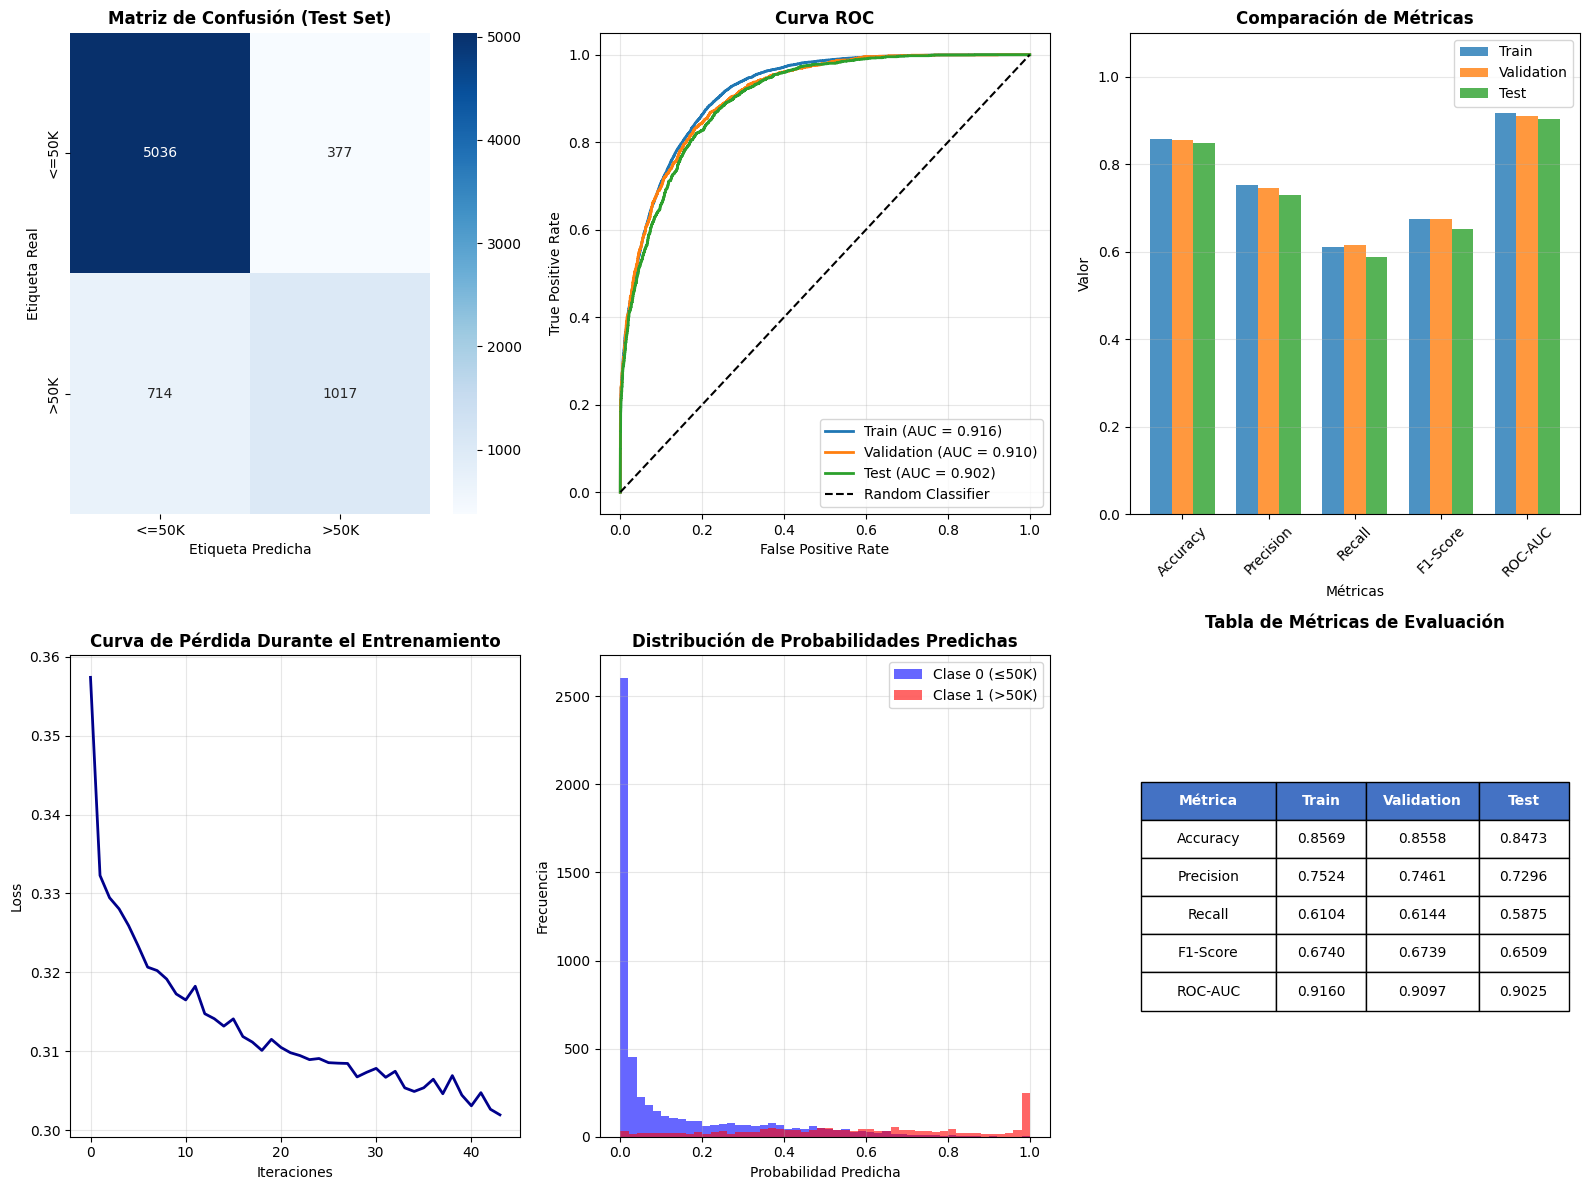

In [ ]:
# ============================================================================
# VISUALIZACIONES
# ============================================================================

print("\n[8] GENERANDO VISUALIZACIONES")
print("-" * 80)

# Crear figura con múltiples subplots
fig = plt.figure(figsize=(16, 12))

# 1. Matriz de confusión
ax1 = plt.subplot(2, 3, 1)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le_target.classes_,
            yticklabels=le_target.classes_)
plt.title('Matriz de Confusión (Test Set)', fontsize=12, fontweight='bold')
plt.ylabel('Etiqueta Real')
plt.xlabel('Etiqueta Predicha')

# 2. Curva ROC
ax2 = plt.subplot(2, 3, 2)
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_proba)
fpr_val, tpr_val, _ = roc_curve(y_val, y_val_proba)
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_proba)

plt.plot(fpr_train, tpr_train, label=f'Train (AUC = {metrics_train["roc_auc"]:.3f})', linewidth=2)
plt.plot(fpr_val, tpr_val, label=f'Validation (AUC = {metrics_val["roc_auc"]:.3f})', linewidth=2)
plt.plot(fpr_test, tpr_test, label=f'Test (AUC = {metrics_test["roc_auc"]:.3f})', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC', fontsize=12, fontweight='bold')
plt.legend()
plt.grid(alpha=0.3)

# 3. Comparación de métricas entre conjuntos
ax3 = plt.subplot(2, 3, 3)
metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
train_values = [metrics_train['accuracy'], metrics_train['precision'],
                metrics_train['recall'], metrics_train['f1'], metrics_train['roc_auc']]
val_values = [metrics_val['accuracy'], metrics_val['precision'],
              metrics_val['recall'], metrics_val['f1'], metrics_val['roc_auc']]
test_values = [metrics_test['accuracy'], metrics_test['precision'],
               metrics_test['recall'], metrics_test['f1'], metrics_test['roc_auc']]

x = np.arange(len(metrics_names))
width = 0.25

plt.bar(x - width, train_values, width, label='Train', alpha=0.8)
plt.bar(x, val_values, width, label='Validation', alpha=0.8)
plt.bar(x + width, test_values, width, label='Test', alpha=0.8)
plt.xlabel('Métricas')
plt.ylabel('Valor')
plt.title('Comparación de Métricas', fontsize=12, fontweight='bold')
plt.xticks(x, metrics_names, rotation=45)
plt.legend()
plt.ylim([0, 1.1])
plt.grid(axis='y', alpha=0.3)

# 4. Curva de pérdida durante el entrenamiento
ax4 = plt.subplot(2, 3, 4)
plt.plot(mlp_final.loss_curve_, linewidth=2, color='darkblue')
plt.xlabel('Iteraciones')
plt.ylabel('Loss')
plt.title('Curva de Pérdida Durante el Entrenamiento', fontsize=12, fontweight='bold')
plt.grid(alpha=0.3)

# 5. Distribución de predicciones (probabilidades)
ax5 = plt.subplot(2, 3, 5)
plt.hist(y_test_proba[y_test == 0], bins=50, alpha=0.6, label='Clase 0 (≤50K)', color='blue')
plt.hist(y_test_proba[y_test == 1], bins=50, alpha=0.6, label='Clase 1 (>50K)', color='red')
plt.xlabel('Probabilidad Predicha')
plt.ylabel('Frecuencia')
plt.title('Distribución de Probabilidades Predichas', fontsize=12, fontweight='bold')
plt.legend()
plt.grid(alpha=0.3)

# 6. Tabla de resumen de métricas
ax6 = plt.subplot(2, 3, 6)
ax6.axis('tight')
ax6.axis('off')

table_data = [
    ['Métrica', 'Train', 'Validation', 'Test'],
    ['Accuracy', f"{metrics_train['accuracy']:.4f}", f"{metrics_val['accuracy']:.4f}", f"{metrics_test['accuracy']:.4f}"],
    ['Precision', f"{metrics_train['precision']:.4f}", f"{metrics_val['precision']:.4f}", f"{metrics_test['precision']:.4f}"],
    ['Recall', f"{metrics_train['recall']:.4f}", f"{metrics_val['recall']:.4f}", f"{metrics_test['recall']:.4f}"],
    ['F1-Score', f"{metrics_train['f1']:.4f}", f"{metrics_val['f1']:.4f}", f"{metrics_test['f1']:.4f}"],
    ['ROC-AUC', f"{metrics_train['roc_auc']:.4f}", f"{metrics_val['roc_auc']:.4f}", f"{metrics_test['roc_auc']:.4f}"]
]

table = ax6.table(cellText=table_data, cellLoc='center', loc='center',
                  colWidths=[0.3, 0.2, 0.25, 0.2])
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2)

# Estilo para el encabezado
for i in range(4):
    table[(0, i)].set_facecolor('#4472C4')
    table[(0, i)].set_text_props(weight='bold', color='white')

plt.title('Tabla de Métricas de Evaluación', fontsize=12, fontweight='bold', pad=20)

plt.tight_layout()
plt.savefig('mlp_resultados_completos.png', dpi=300, bbox_inches='tight')
print("Visualizaciones guardadas en 'mlp_resultados_completos.png'")
plt.show()

In [ ]:
# ============================================================================
# RESUMEN FINAL
# ============================================================================

print("\n" + "="*80)
print("RESUMEN FINAL DEL MODELO")
print("="*80)
print(f"\nArquitectura final del MLP:")
print(f"  - Capas ocultas: {mlp_final.hidden_layer_sizes}")
print(f"  - Función de activación: {mlp_final.activation}")
print(f"  - Parámetro de regularización (alpha): {mlp_final.alpha}")
print(f"  - Tasa de aprendizaje inicial: {mlp_final.learning_rate_init}")
print(f"  - Número de iteraciones: {mlp_final.n_iter_}")

print(f"\nRendimiento en conjunto de prueba:")
print(f"  - Accuracy: {metrics_test['accuracy']:.4f}")
print(f"  - F1-Score: {metrics_test['f1']:.4f}")
print(f"  - ROC-AUC: {metrics_test['roc_auc']:.4f}")

print("\n" + "="*80)
print("ANÁLISIS COMPLETADO")
print("="*80)


RESUMEN FINAL DEL MODELO

Arquitectura final del MLP:
  - Capas ocultas: (100,)
  - Función de activación: relu
  - Parámetro de regularización (alpha): 0.0001
  - Tasa de aprendizaje inicial: 0.01
  - Número de iteraciones: 44

Rendimiento en conjunto de prueba:
  - Accuracy: 0.8473
  - F1-Score: 0.6509
  - ROC-AUC: 0.9025

ANÁLISIS COMPLETADO
